# Dask bag

Dask proposes "big data" collections with a small set of high-level primitives like `map`, `filter`, `groupby`, and `join`.  With these common patterns we can often handle computations that are more complex than map, but are still structured.

- Dask-bag excels in processing data that can be represented as a sequence of arbitrary inputs ("messy" data)
- When you encounter a set of data with a format that does not enforce strict structure and datatypes.

**Related Documentation**

*  [Bag Documenation](http://dask.pydata.org/en/latest/bag.html)
*  [Bag API](http://dask.pydata.org/en/latest/bag-api.html)

In [10]:
import dask.bag as db
from lorem import sentence

In [11]:
b = db.from_sequence(range(2,20))

In [12]:
b.compute()  # Gather results back to local process

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [13]:
b.map(lambda x : x//2).compute() # compute length of each element and collect results

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]

In [14]:
b.product(b).compute() # Cartesian product of each pair 
# of elements in two sequences (or the same sequence in this case)

[(2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (4, 18),
 (4, 19),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (5, 18),
 (5, 19),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (6, 15),
 (6, 16),
 (6, 17),
 (6, 18),
 (6, 19),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16)

In [15]:
# Chain operations to construct more complex computations

(b.filter(lambda x: x % 2 > 0)
  .product(b)
  .filter( lambda v : v[0] % v[1] == 0 and v[0] != v[1])
  .compute())

[(9, 3), (15, 3), (15, 5)]

## Daily stock example

Let's use the bag interface to read the json files containing time series.

Each line is a JSON encoded dictionary with the following keys
- timestamp: Day.
- close: Stock value at the end of the day.
- high: Highest value.
- low: Lowest value.
- open: Opening price.

In [16]:
import dask.bag as db
import json
stocks = db.read_text('../data/daily-stock/*.json')

In [17]:
stocks.npartitions

21

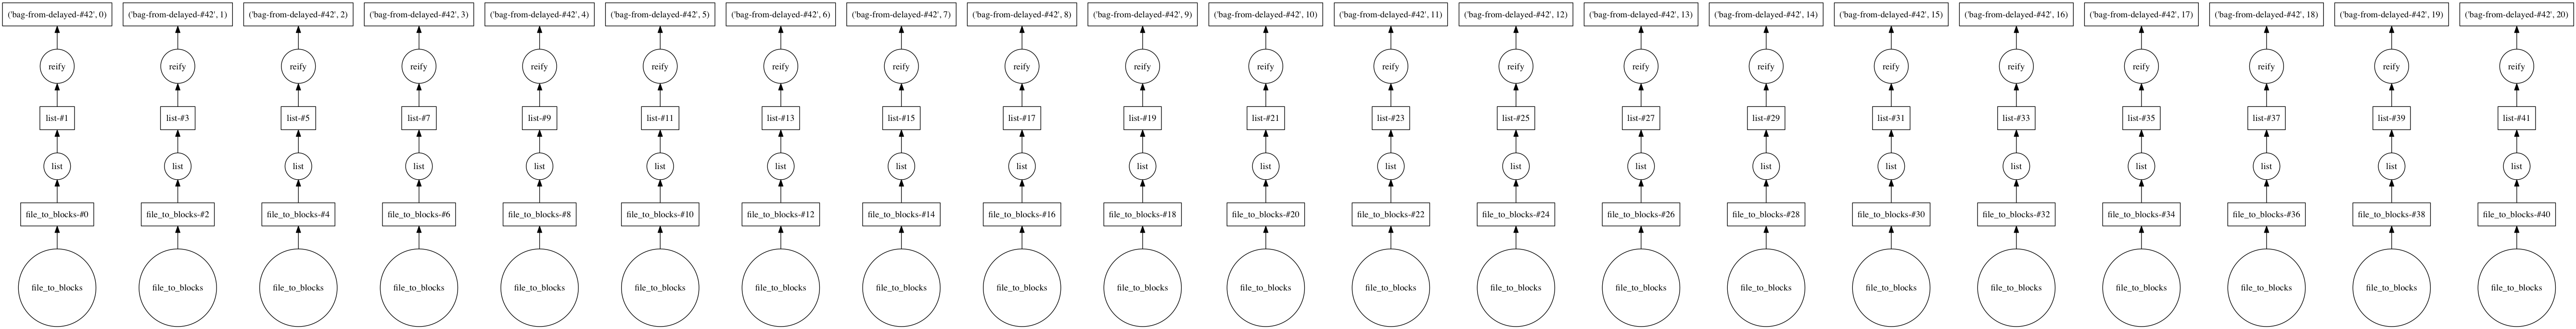

In [18]:
stocks.visualize()

In [19]:
import json
js = stocks.map(json.loads)

js.take(1)

({'timestamp': '2013-07-23 09:00:00',
  'close': 65.551,
  'high': 65.558,
  'low': 65.501,
  'open': 65.51},)

In [20]:
import os, sys
from glob import glob
import pandas as pd
import json

here = os.getcwd() # get the current directory
filenames = sorted(glob(os.path.join(here,'..','data', 'daily-stock', '*.json')))

In [21]:
from tqdm import tqdm_notebook as tqdm
for fn in tqdm(filenames):
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')

In [22]:
filenames = sorted(glob(os.path.join(here,'..','data', 'daily-stock', '*.h5')))

In [23]:
series = {}
for fn in filenames:   # Simple map over filenames
    series[fn] = pd.read_hdf(fn)['close']

results = {}

for a in filenames:    # Doubly nested loop over the same collection
    for b in filenames:  
        if a != b:     # Filter out bad elements
            results[a, b] = series[a].corr(series[b])  # Apply function

((a, b), corr) = max(results.items(), key=lambda kv: kv[1])  # Reduction

In [24]:
a, b, corr

('/Users/navaro/PycharmProjects/big-data/notebooks/../data/daily-stock/aet.h5',
 '/Users/navaro/PycharmProjects/big-data/notebooks/../data/daily-stock/luv.h5',
 0.9413176064560879)

## Dask.bag methods

We can construct most of the above computation with the following Spark/Dask.bag methods:

*  `collection.map(function)`: apply function to each element in collection
*  `collection.product(collection)`: Create new collection with every pair of inputs
*  `collection.filter(predicate)`: Keep only elements of colleciton that match the predicate function
*  `collection.max()`: Compute maximum element


In [25]:
%%time

import dask.bag as db

b = db.from_sequence(filenames)
series = b.map(lambda fn: pd.read_hdf(fn)['close'])

corr = (series.product(series)
              .filter(lambda ab: not (ab[0] == ab[1]).all())
              .map(lambda ab: ab[0].corr(ab[1])).max())

result = corr.compute()

CPU times: user 3.59 s, sys: 1.9 s, total: 5.48 s
Wall time: 6.07 s


In [26]:
result

0.9413176064560879

### Wordcount with Dask bag

In [30]:
import dask.bag as db
import glob
b = db.read_text(glob.glob('sample*.txt'))
wordcount = b.str.split().flatten().frequencies().topk(10, lambda x: x[1])
wordcount.compute()

[('ut', 56),
 ('numquam', 54),
 ('est', 53),
 ('porro', 52),
 ('consectetur', 48),
 ('tempora', 48),
 ('neque', 48),
 ('modi', 47),
 ('quaerat', 47),
 ('non', 46)]

## Genome example
We will use a Dask bag to calculate the frequencies of sequences of five bases, and then sort the sequences into descending order ranked by their frequency.

- First we will define some functions to split the bases into sequences of a certain size

### Exercise 9.1

- Implement a function `group_characters(line, n=5)` to group `n` characters together and create a sequence of 5 bases. `line` is a text line in genome.txt file.
    
- Implement `group_and_split(line)`
```py
>>> group_and_split('abcdefghijklmno')
['abcde', 'fghij', 'klmno']
```

- Use the dask bag to compute  the frequencies of sequences of five bases.

### Exercise 9.2

- Create a function that can read several [FASTA files](http://www.cbs.dtu.dk/services/NetGene2/fasta.php) and compute the frequencies of a given sequence.

# Some remarks about bag

*  Higher level dask collections include functions for common patterns
*  Move data to collection, construct lazy computation, trigger at the end
*  Use Dask.bag (`product + map`) to handle nested for loop

Bags have the following known limitations

1.  Bag operations tend to be slower than array/dataframe computations in the
    same way that Python tends to be slower than NumPy/Pandas
2.  ``Bag.groupby`` is slow.  You should try to use ``Bag.foldby`` if possible.
    
3. Check the [API](http://dask.pydata.org/en/latest/bag-api.html) 

4. `dask.dataframe` can be faster than `dask.bag`.  But sometimes it is easier to load and clean messy data with a bag. We will see later how to transform a bag into a `dask.dataframe` with the [to_dataframe](http://dask.pydata.org/en/latest/bag-api.html#dask.bag.Bag.to_dataframe) method.